# Censored Data Models

*Inspiration:*[censored_data.ipynb pymc3](https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/censored_data.ipynb)

In [1]:
using Turing, Distributions
using Random, Plots, StatsPlots
using MCMCChains

Turing.turnprogress(false)

Random.seed!(1);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/riteshk/.julia/packages/Turing/yF1Mq/src/Turing.jl:24


This example notebook on Bayesian survival analysis touches on the point of censored data. Censoring is a form of missing-data problem, in which observations greater than a certain threshold are clipped down to that threshold, or observations less than a certain threshold are clipped up to that threshold, or both. These are called right, left and interval censoring, respectively. In this example notebook we consider interval censoring.

Censored data arises in many modelling problems. Two common examples are:

*Survival analysis*: when studying the effect of a certain medical treatment on survival times, it is impossible to prolong the study until all subjects have died. At the end of the study, the only data collected for many patients is that they were still alive for a time period  𝑇  after the treatment was administered: in reality, their true survival times are greater than  𝑇 .

**Sensor saturation:** a sensor might have a limited range and the upper and lower limits would simply be the highest and lowest values a sensor can report. For instance, many mercury thermometers only report a very narrow range of temperatures.

This example notebook presents two different ways of dealing with censored data in *Turing*:

An **imputed censored model**, which represents censored data as parameters and makes up plausible values for all censored values. As a result of this imputation, this model is capable of generating plausible sets of made-up values that would have been censored. Each censored element introduces a random variable.

An **unimputed censored model**, where the censored data are integrated out and accounted for only through the log-likelihood. This method deals more adequately with large amounts of censored data and converges more quickly.
**[This still has to be implemented]**

To establish a baseline we compare to an uncensored model of the uncensored data.

In [2]:
# Produce normally distributed samples

size = 500
mu = 13
sigma = 5
samples = rand(Normal(mu, sigma), size)

# Set censoring limits
high = 16
low = -1

# Censor samples
censored = samples[(samples .> low) .& (samples .< high)];

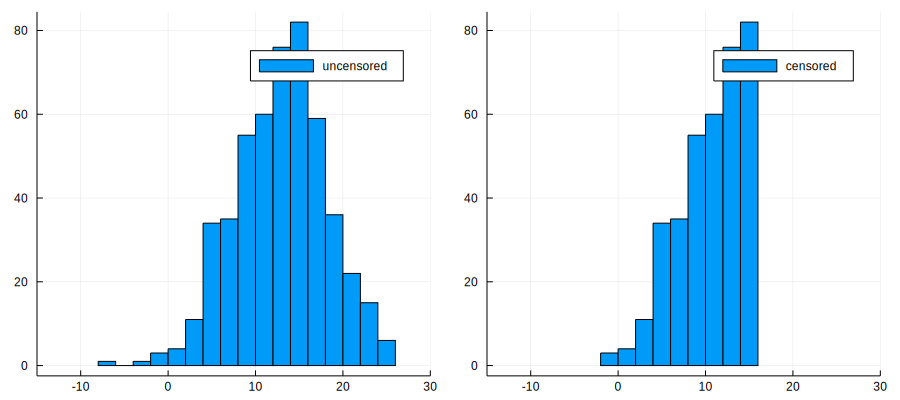

In [3]:
h1 = histogram(samples, bins=20, label="uncensored", xlims=(-15, 30))
h2 = histogram(censored, bins=15, label="censored", xlims=(-15, 30));
plot(h1, h2, layout=(1, 2), legend=true, size=(900, 400))

## Baseline - Uncensored Model of Uncensored Data

In [4]:
@model uncensored_model(samples, high, low) = begin
    μ ~ Normal(0, (high-low)/2)
    σ ~ TruncatedNormal(0, (high-low)/2, 0, Inf)
    N = length(samples)
    for i in 1:N
        samples[i] ~ Normal(μ, σ)
    end
end

uncensored_model (generic function with 4 methods)

## Model 1 - Imputed Censored Model of Censored Data

In this model, we impute the censored values from the same distribution as the uncensored data. Sampling from the posterior generates possible uncensored data sets.

In [28]:
n_right_censored = length(samples[samples .>= high])
n_left_censored = length(samples[samples .<= low])
n_observed = length(samples) - n_right_censored - n_left_censored

@model imputed_censored_model(censored, high, low) = begin
    N = length(censored)
    
    μ ~ Normal(0, (high-low)/2)
    σ ~ TruncatedNormal(0, (high-low)/2, 0, Inf)
    
    right_censored = Vector(undef, n_right_censored)
    left_censored = Vector(undef, n_left_censored)
    for i in 1:n_right_censored
        right_censored[i] ~ TruncatedNormal(0, (high-low)/2, high, Inf)
    end
    for i in 1:n_left_censored
        left_censored[i] ~ TruncatedNormal(0, (high-low)/2, -Inf, low)
    end
    for i in 1:N
        censored[i] ~ Normal(μ, σ)
    end
end

imputed_censored_model (generic function with 4 methods)

## Sampling

In [7]:
# Model of Uncensored Data

# Set the automatic differentiation backend to forward differentiation.
# Note, this is temporary while the reverse differentiation functionality
# is being improved.
Turing.setadbackend(:forward_diff)

model = uncensored_model(samples, high, low)
sampler = Gibbs(1500, HMC(1, 0.05, 10, :μ, :σ))
uncen_chains = mapreduce(c -> sample(model, sampler), chainscat, 1:3);

┌ Info: [Gibbs] Finished with
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/gibbs.jl:177
┌ Info:   Running time    = 30.84662942400001;
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/gibbs.jl:178
┌ Info: [Gibbs] Finished with
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/gibbs.jl:177
┌ Info:   Running time    = 27.556948707999982;
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/gibbs.jl:178
┌ Info: [Gibbs] Finished with
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/gibbs.jl:177
┌ Info:   Running time    = 26.99740729900002;
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/gibbs.jl:178


In [8]:
uncen_chain = uncen_chains[:,:,1]
print(uncen_chain)

Object of type Chains, with data of type 1500×7×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:1500
Thinning interval = 1
Chains            = 1
Samples per chain = 1500
internals         = elapsed, epsilon, eval_num, lf_num, lp
parameters        = μ, σ

parameters
    Mean    SD   Naive SE  MCSE     ESS  
μ 12.8230 0.4356   0.0112 0.0142 935.4618
σ  5.2479 0.2119   0.0055 0.0099 458.7870



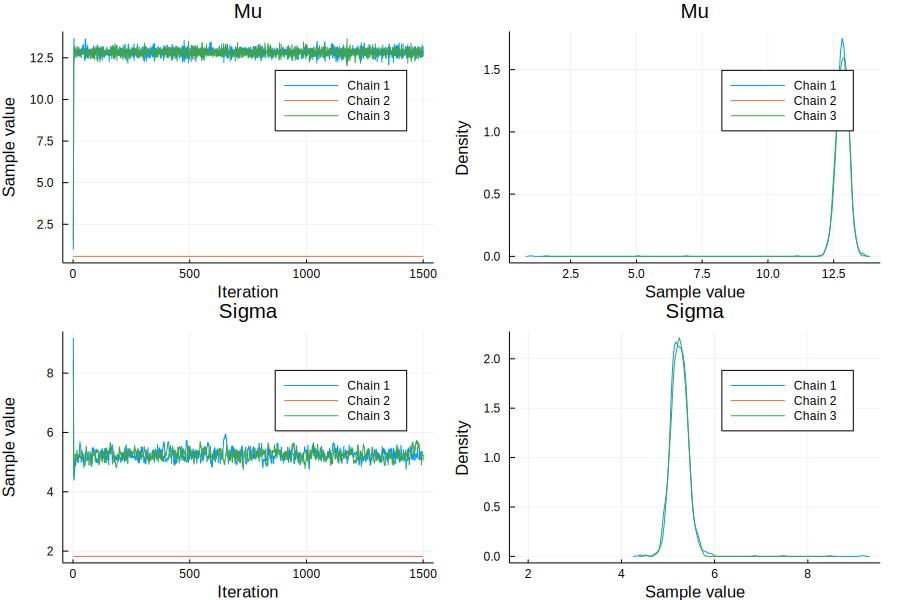

In [9]:
p1 = plot(uncen_chains[:, "μ", :], legend=true, title="Mu")
p2 = plot(uncen_chains[:, "σ", :], legend=true, title="Sigma")
plot(p1, p2, layout=(2, 1), size=(900, 600), colordim=:parameter)

In [29]:
# Imputed censored model

model = imputed_censored_model(samples, high, low)
# gmm_sampler = Gibbs(100, HMC(1, 0.05, 10, :μ, :σ))
sampler = NUTS(100, 0.65)
cen_chains = mapreduce(c -> sample(model, sampler), chainscat, 1:3);

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:245
┌ Info: [Turing] found initial ϵ: 0.0546875
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:237
┌ Info:  Adapted ϵ = 0.019768166898289634, std = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

[NUTS] Finished with
  Running time        = 456.7848155719999;
  #lf / sample        = 0.0;
  #evals / sample     = 1631.0;
  pre-cond. metric    = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,....


┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:245
┌ Info: [Turing] found initial ϵ: 0.06914062500000001
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:237
┌ Info:  Adapted ϵ = 0.03428663151608045, std = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

[NUTS] Finished with
  Running time        = 475.77334900699987;
  #lf / sample        = 0.0;
  #evals / sample     = 1678.43;
  pre-cond. metric    = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,....


┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:245
┌ Info: [Turing] found initial ϵ: 0.03906250000000001
└ @ Turing.Inference /home/riteshk/.julia/packages/Turing/yF1Mq/src/inference/support/hmc_core.jl:237
┌ Info:  Adapted ϵ = 0.05011717050047597, std = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

[NUTS] Finished with
  Running time        = 475.8792736800001;
  #lf / sample        = 0.0;
  #evals / sample     = 1657.97;
  pre-cond. metric    = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0,....


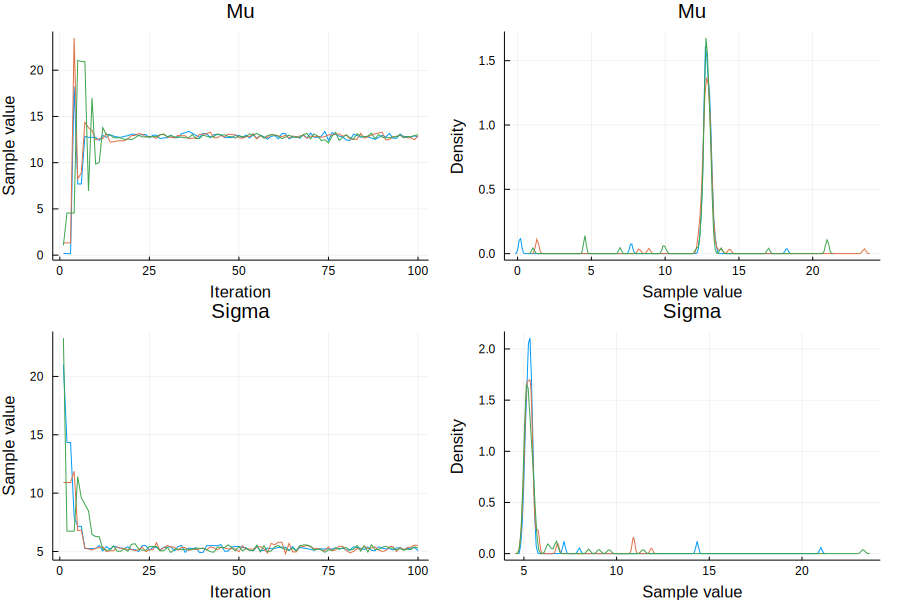

In [36]:
p1 = plot(cen_chains[:,"μ",:], title="Mu");
p2 = plot(cen_chains[:,"σ",:], title="Sigma");
plot(p1, p2, layout=(2, 1), size=(900, 600), colordim=:parameter)